In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(font_scale=1.5)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (20,10)

## Read Data

In [6]:
train_df = pd.read_csv('data/train.csv')
macro_df = pd.read_csv("data/macro.csv")
df = train_df.merge(macro_df, how='inner', on='timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['price_doc_log'] = df['price_doc'].apply(np.log10)
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm,price_doc_log
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,6.767156
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,6.778151
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,6.755875
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,7.117271
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,7.213025


### Columns

In [7]:
all_cols = list(df)
train_cols = list(train_df)
macro_cols = list(macro_df)

# Explore Features

## Train Data

### Dependant Variable: Price Doc

#### Check for outliers

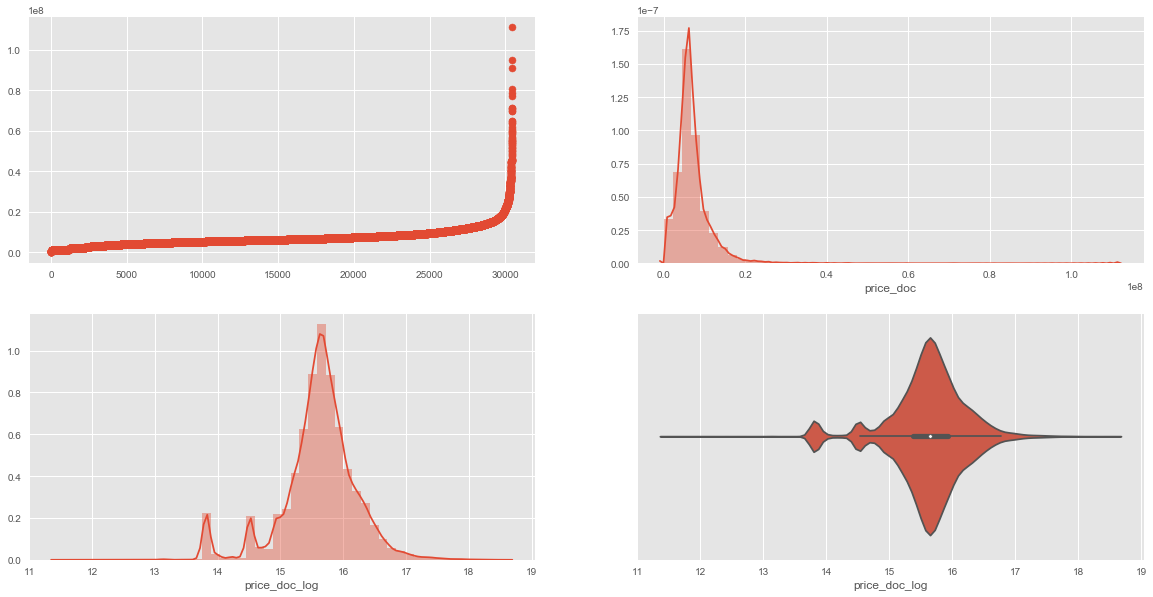

In [8]:
plt.subplot(221)
plt.scatter(x=range(len(df.index)), y=np.sort(df.price_doc.values))

sns.distplot(df.price_doc, kde=True, norm_hist=False, ax=plt.subplot(222))

# Taking Log
df['price_doc_log']=np.log(df.price_doc+0.5)
sns.distplot(df['price_doc_log'], kde=True, norm_hist=False,  ax=plt.subplot(223))

# Taking Log
sns.violinplot(df['price_doc_log'], ax=plt.subplot(224))

### Median House prices over time

In [9]:
df['yearmonth'] = df['timestamp'].apply(lambda x: x.strftime('%m-%Y'))
grouped_df = df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text xticklabel objects>)

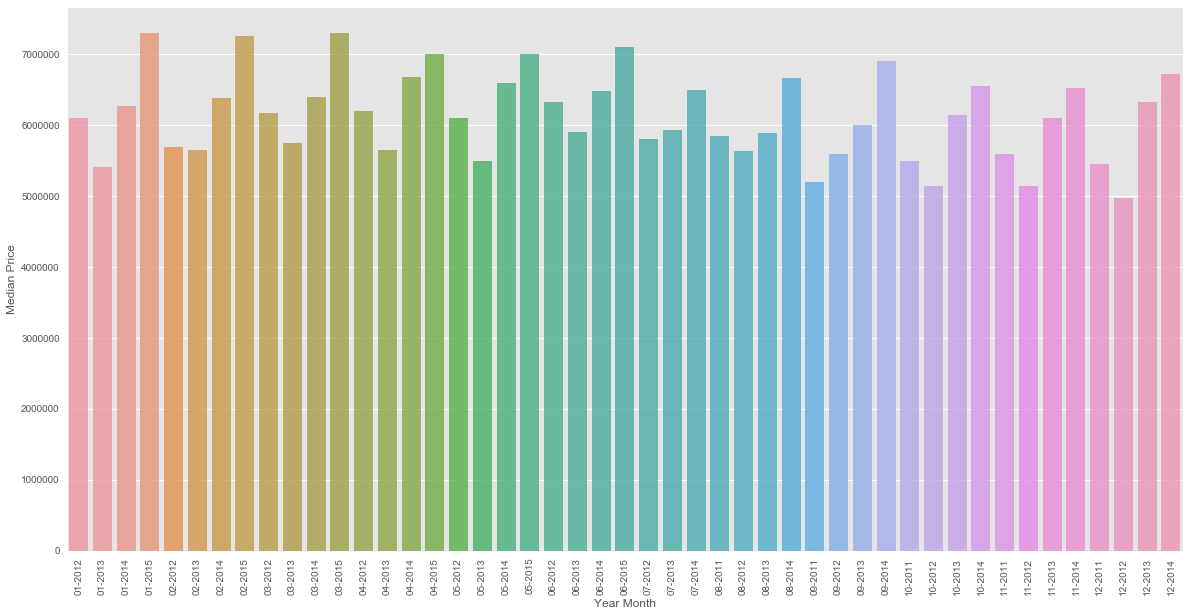

In [10]:
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')

### Relationship of *price_doc* with macro variables

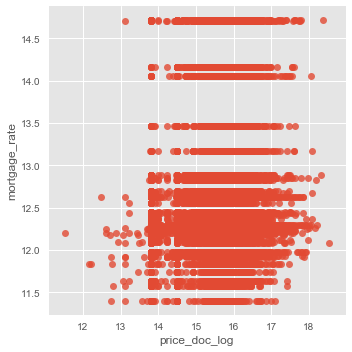

In [11]:
sns.lmplot(x='price_doc_log', y='mortgage_rate', data=df, order=2, fit_reg=False)

### Count of types of other features

In [12]:
train_df.get_dtype_counts()

float64    119
int64      157
object      16
dtype: int64

Clearly, Majority of them are numerical variables with 15 factor variables and 1 date variable.

### Number of NaNs in each column

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

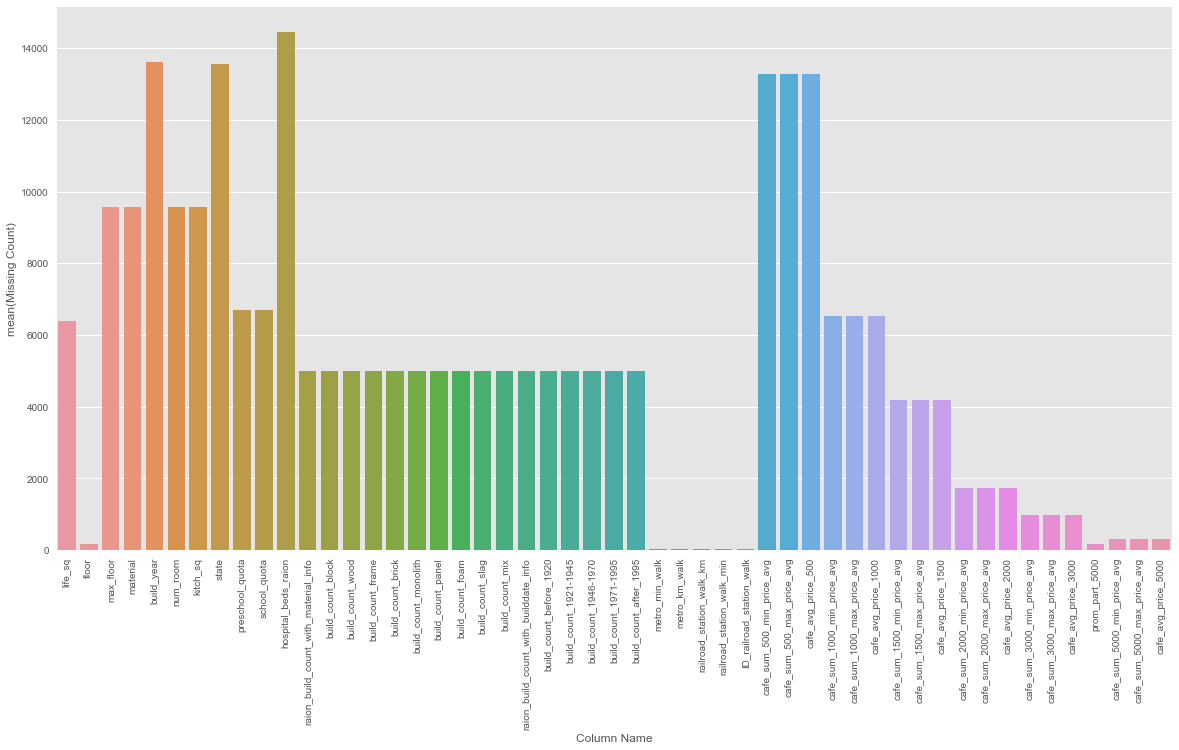

In [13]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ["Column Name", "Missing Count",]
missing_df = missing_df.ix[missing_df['Missing Count']>0]
sns.barplot(x="Column Name", y = "Missing Count", data=missing_df)
plt.xticks(rotation='vertical')

### Find the important variables using a Boosted model

#### LabelEncdoing Categorical variables

In [17]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))

In [19]:
X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
y = train_df.price_doc.values

In [21]:
reg_lgb = lgb.LGBMRegressor()
reg_lgb.fit(X,y)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
       fair_c=1.0, gaussian_eta=1.0, huber_delta=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, max_drop=50, min_child_samples=10,
       min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
       num_leaves=31, objective='regression', poisson_max_delta_step=0.7,
       reg_alpha=0, reg_lambda=0, seed=0, silent=True, skip_drop=0.5,
       subsample=1, subsample_for_bin=50000, subsample_freq=1,
       uniform_drop=False, xgboost_dart_mode=False)

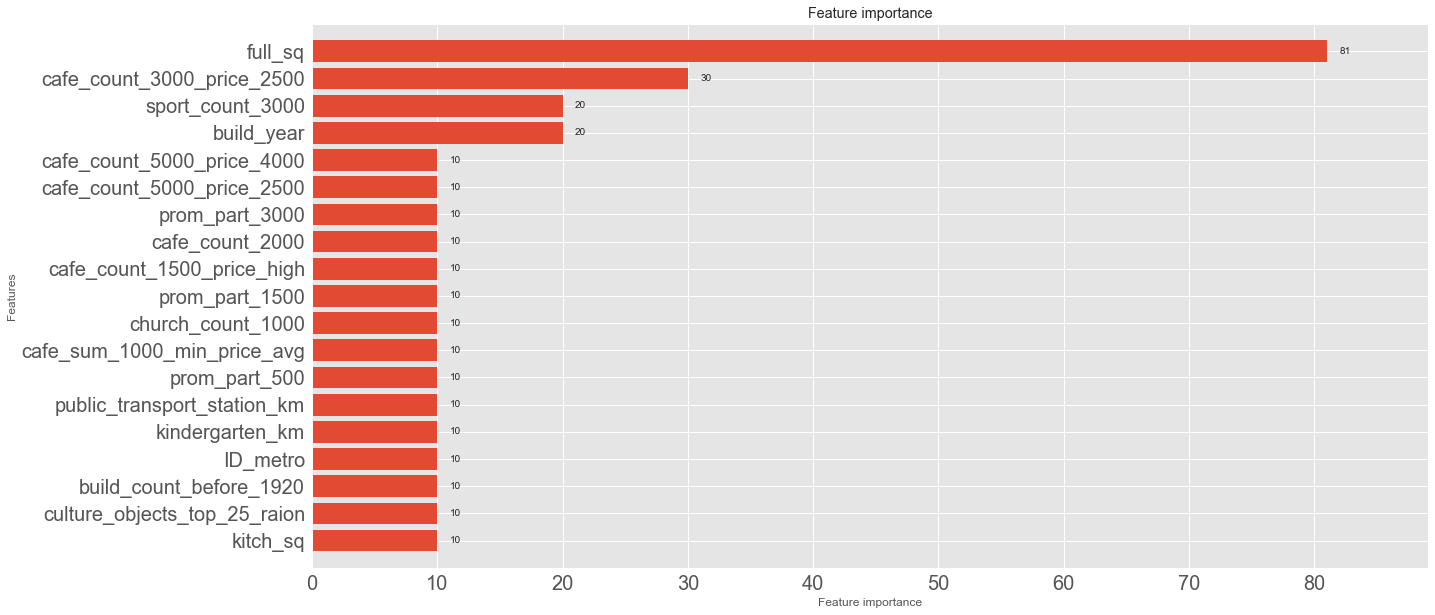

In [22]:
lgb.plot_importance(reg_lgb, max_num_features=50, height=0.8)

### Top 5 features
1. full_sq - total area in square meters, including loggias, balconies and other non-residential areas
2. life_sq - living area in square meters, excluding loggias, balconies and other non-residential areas
3. floor - for apartments, floor of the building
4. max_floor - number of floors in the building
5. build_year - year built

### Correlation of Features

In [23]:
corr_df=pd.DataFrame(columns=['feature','pearson', 'kendall', 'spearman'])

## Economical Data

In [24]:
macro_columns= ['timestamp', 'oil_urals', 'gdp_quart_growth', 'cpi', 'usdrub', 'salary_growth', 'unemployment', 
               'average_provision_of_build_contract_moscow', 'mortgage_rate', 'deposits_rate','deposits_growth',
               'rent_price_3room_eco','rent_price_3room_bus']

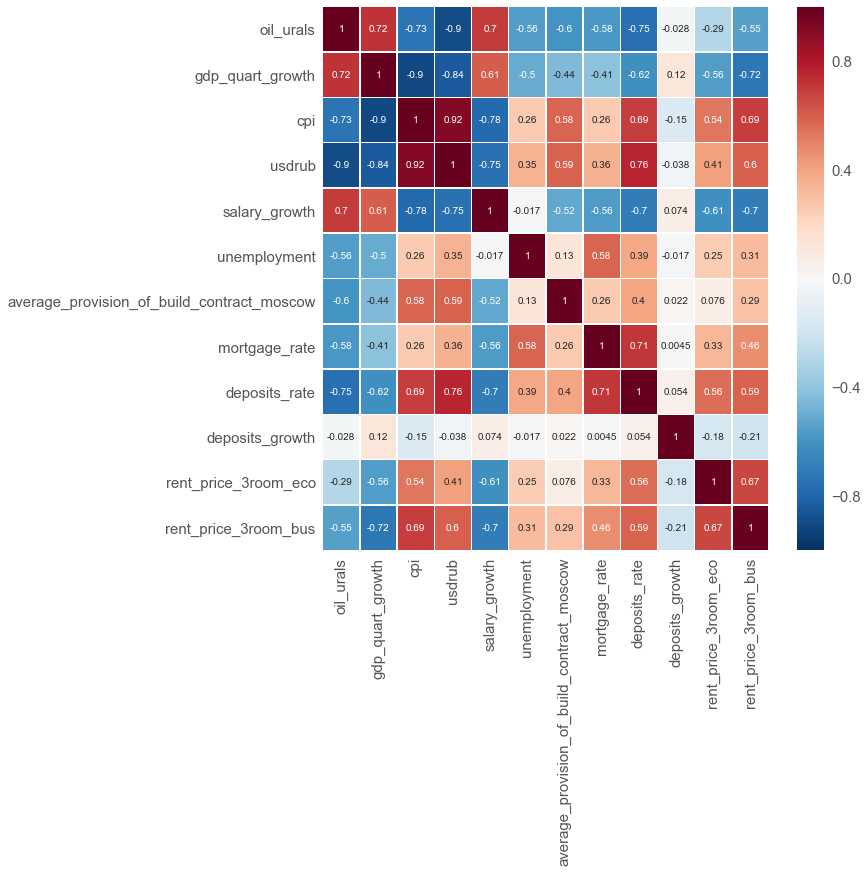

In [27]:
corr = macro_df.loc[:, macro_columns].corr(method='pearson')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)